In [302]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

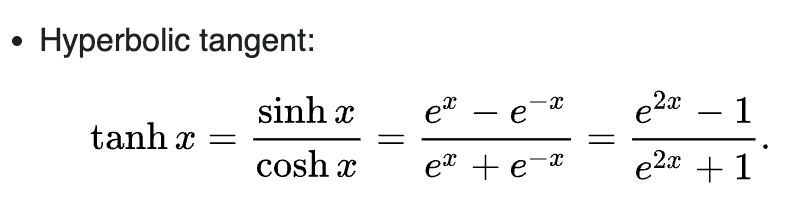

In [303]:
class Value:
  """ stores a single scalar value and its gradient """

  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    
    out._backward = _backward
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
      
    out._backward = _backward
    return out
  
  def exp(self):
     x = self.data
     out = Value(math.exp(x) , (self, ), 'exp')

     def _backward():
        self.grad += out.data * out.grad
      
     out._backward = _backward
     return out
  
  def tanh(self):
    # refer to hyperbolic tangent screenshot above
    x = self.data
    t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward
    return out
  
  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out
  

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    
    build_topo(self)
    self.grad = 1

    for node in reversed(topo):
      node._backward()


  def __neg__(self): # -self
      return self * -1
  
  def __radd__(self, other): # other + self
      return self + other
  
  def __sub__(self, other): # self - other
      return self + (-other)
  
  def __rsub__(self, other): # other - self
      return other + (-self)
  
  def __rmul__(self, other): # other * self
      return self * other
  
  def __truediv__(self, other): # self / other
      return self * other**-1
  
  def __rtruediv__(self, other): # other / self
      return other * self**-1
  
  def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"




In [304]:
from graphviz import Digraph

def trace(root):
  # builds the set of all nodes and edges in a graph
  nodes, edges = set(), set()
  
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and  connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    #  connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

dL/dc = dL/dd * dd/dc

dd/dc = 1
so, dL/dc = dL/dd which is -2.0



Similarly

dL/db = dL/de * de/db
      = -2.0 * a
      = -4.0

dL/da = dL/de * de/da
      = -2.0 * b
      = 6.0

### Activation function tanh

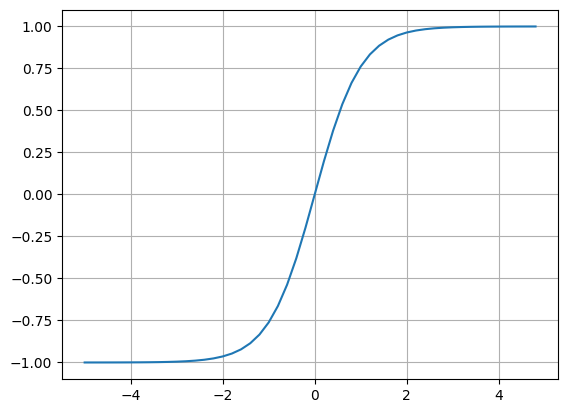

In [305]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [306]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()


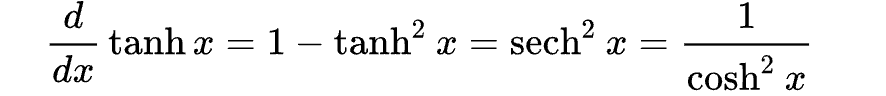

What is Topological Sort?
Topological Sort is a linear ordering of vertices in a Directed Acyclic Graph (DAG) such that for every directed edge u → v, vertex u appears before v in the ordering.

- Applies only to DAGs (Directed Acyclic Graphs), and is not possible for cyclic or undirected graphs.
- It doesn’t “traverse” all vertices like BFS/DFS; instead, it represents dependency ordering between them.
- Used in problems like task scheduling, build order, course prerequisite ordering, etc.

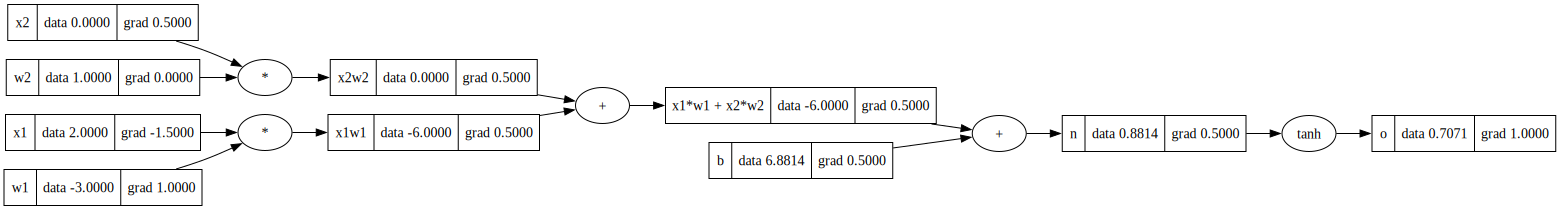

In [307]:
draw_dot(o)

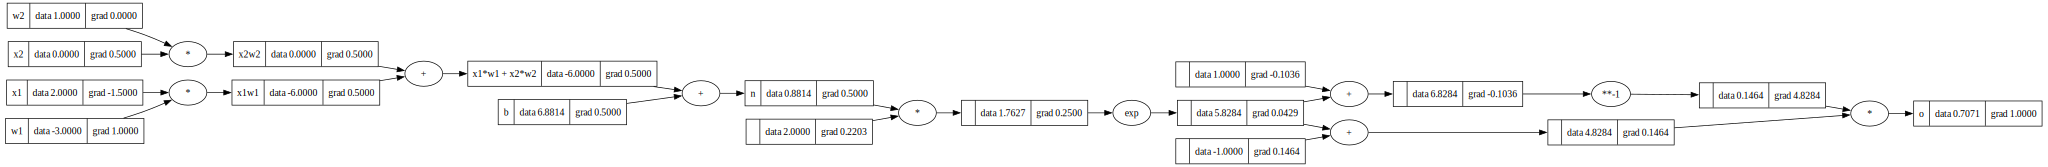

In [308]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# ---
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ---

o.label = 'o'
o.backward()
draw_dot(o)


In [309]:
x1._prev

set()

In [310]:
import torch

In [311]:
# inputs x1 and x2
x1 = torch.Tensor([2.0]).double()                     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                     ; x2.requires_grad = True

# weights w1, w1
w1 = torch.Tensor([-3.0]).double()                    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                     ; w2.requires_grad = True

# bias of the neuron
b = torch.Tensor([6.8813735870195432]).double()       ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('-' * 5)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 0.0


In [312]:
class Neuron:

  #nin: number of inputs
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    # act -> activation
    act = sum((w1 * x1 for w1, x1 in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

In [313]:
x = [2.0, 3.0]
n = Neuron(2)
n(x) # n(x) => n.__call__(x)

Value(data=0.9986587552063693, grad=0.0)

In [314]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params


In [315]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=0.9986216721135522, grad=0.0),
 Value(data=0.1346949615522341, grad=0.0),
 Value(data=-0.20052408491888704, grad=0.0)]

In [316]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [317]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.9684471172023743, grad=0.0)

In [318]:
print(n.parameters())
print(len(n.parameters()))

[Value(data=0.8229134286071751, grad=0.0), Value(data=0.4710782442679191, grad=0.0), Value(data=0.24111164140526542, grad=0.0), Value(data=0.954781749189346, grad=0.0), Value(data=0.4761779685113814, grad=0.0), Value(data=0.41544119762523724, grad=0.0), Value(data=-0.25995382761065877, grad=0.0), Value(data=-0.9454042189363616, grad=0.0), Value(data=-0.7564166550161595, grad=0.0), Value(data=0.2031803129184715, grad=0.0), Value(data=0.28212207271500533, grad=0.0), Value(data=-0.2399493103484296, grad=0.0), Value(data=-0.5338825615482203, grad=0.0), Value(data=0.7250864701540738, grad=0.0), Value(data=0.8246451437932996, grad=0.0), Value(data=-0.19735395953750645, grad=0.0), Value(data=0.9360057906351691, grad=0.0), Value(data=0.8427185235707118, grad=0.0), Value(data=0.08226375230006511, grad=0.0), Value(data=-0.7391449497218727, grad=0.0), Value(data=-0.6307698682138967, grad=0.0), Value(data=-0.3978680450402716, grad=0.0), Value(data=-0.8751137568254139, grad=0.0), Value(data=0.35234

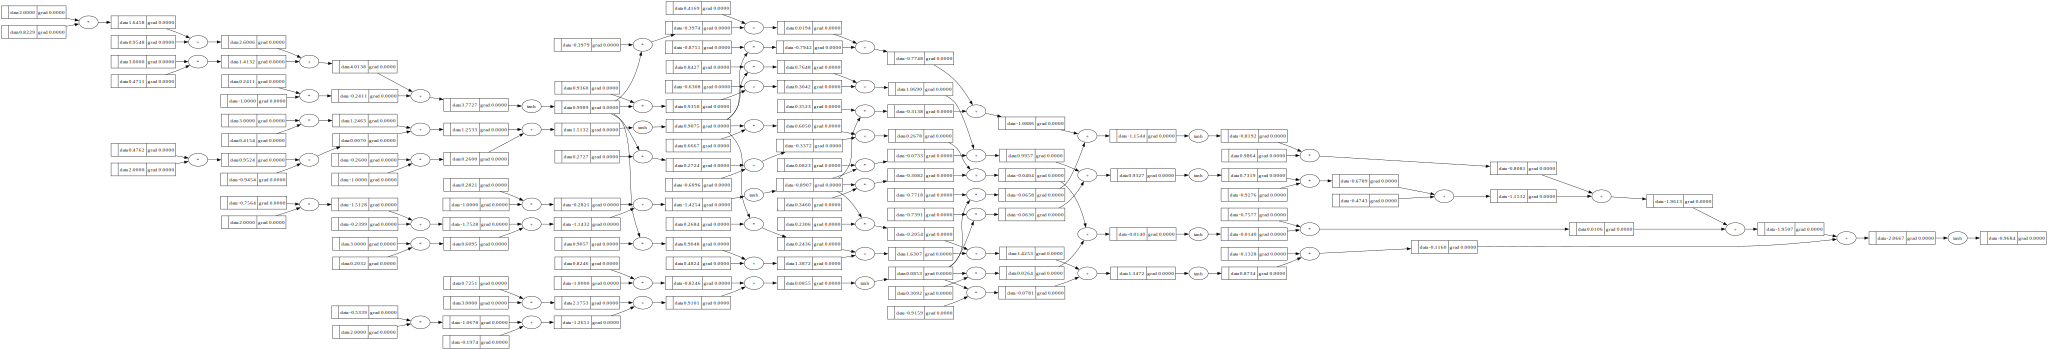

In [319]:
draw_dot(n(x))

In [320]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
] # inputs

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Loss is the single number which measures how well the neural network is performing

In [321]:
ypred = [n(x) for x in xs]
# ygt -> y ground truths

# MSE - Mean Squared Loss
loss_indv = [(ygt - yout)**2  for ygt, yout in zip(ys, ypred)]
print(loss_indv)
loss = sum(loss_indv)
loss


[Value(data=3.874784053222338, grad=0.0), Value(data=0.5857721084737422, grad=0.0), Value(data=1.450724843919401, grad=0.0), Value(data=2.5758023862380934, grad=0.0)]


Value(data=8.487083391853574, grad=0.0)

In [322]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 8.487083391853574
1 6.153363432037752
2 3.265310294467885
3 1.7924271923558437
4 0.5761891400177422
5 0.15641470720935366
6 0.13071966776936383
7 0.11180564580650551
8 0.09736712236692226
9 0.08602365300358934
10 0.07690131434284078
11 0.06942205173657842
12 0.06318946222266164
13 0.05792333515748664
14 0.05342039752313467
15 0.04952985475084632
16 0.046137640169544906
17 0.04315597738798729
18 0.04051628697264406
19 0.03816425707981125


In [323]:
ypred

[Value(data=0.8952640801822098, grad=-0.20947183963558036),
 Value(data=-0.8957740913038545, grad=0.2084518173922909),
 Value(data=-0.9183766303912734, grad=0.16324673921745325),
 Value(data=0.9016677587466215, grad=-0.19666448250675694)]